<a href="https://colab.research.google.com/github/Ms-Noxolo/Team_EN3_Jozi/blob/master/Predict_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team EN3 Unsupervised Learning predict

### Kaggle Submission: Team_EN3_

---


**Team Members:** Refiloe Phipa, Selebogo Mosoeu, Itumeleng Ngoetjana, Noxolo Kheswa, Jamie Japhta, Nkopane

**Supervisor :** Ebrahim Noormahomed

### Table of content
---
1.   [Introduction](#intro)
  *   Background
  *   Problem statement
---
2.   [Load Dependencies](#imports)
---
3.   [Data Overview](#Overview)
  *   Shape
  *   Information about data
  *   features
---
4.   [Data preprocessing](#preprocessing)
  *   Detecting and correcting corrupt data
---
5.   [Exploratory Data Analysis](#EDA)
  *   The number of movies being released
  *   The number of ratings for the movies released
  *   The years with majority of movies being released
  *   The kind of movies that are being released
  *   The runtime of movies that are being released
---
6.   [Modelling](#modelling)
  *   Content Based Filtering
  *   Cosine Similarity
  *   Collaborative Filtering
  *   Movie Recommendations
  *   Surprise
  *   Single Rating Prediction
  *   Multiple Ratings Prediction
---
7.   [Performance Evaluation](#evaluation)
---
8.   [Conclusion](#ending)
---
9.  [References](#ending)
















# 1. Introduction

### Background

In today’s technology driven world, recommender systems are socially and economically critical for ensuring that individuals can make appropriate choices surrounding the content they engage with on a daily basis. One application where this is especially true surrounds movie content recommendations; where intelligent algorithms can help viewers find great titles from tens of thousands of options.

Recommender systems require a broad base access of the user's historical preferences as a result increasing the insights and the accuracy of its future predictions. We can implement an unsupervised machine learning algorithm to solve this problem.

Machine learning is the study of computer algorithms that improve automatically through experience. It is a powerful branch of Artificial intelligence, dating as far back as 1952. Machine learning algorithms build a mathematical model based on sample data, known as "training data", in order to make predictions or decisions without being explicitly programmed to do so.

Unsupervised learning is a type of machine learning that looks for previously undetected patterns in a data set with no pre-existing labels and with a minimum of human supervision.


### Problem Statement

Build an unsupervised machine learning model that is capable of accurately predicting how a user will rate a movie they have not yet viewed based on their historical preferences and/or based on content or collaborative filtering.


# 2. Load Dependencies

In [80]:
# importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math
import random
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
import json
%matplotlib inline
import re
from wordcloud import WordCloud, STOPWORDS

#!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from surprise import NormalPredictor
from surprise import SVDpp
from surprise import NMF
import warnings
warnings.filterwarnings("ignore")

In [81]:
#from google.colab import files
#uploaded = files.upload()

In [82]:
# loading in the datasets
movies = pd.read_csv("data/movies.csv")
links = pd.read_csv('data/links.csv')
imdb = pd.read_csv('data/imdb_data.csv')
tags = pd.read_csv('data/tags.csv')
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
#scores = pd.read_csv('genome_scores.csv')
Sample_Submission = pd.read_csv('sample_submission.csv')

# 3. Data Overview

Below we take a general review and summary of the datasets taking note of the shapes, info and features i.e. columns all of which will help us establish a good approach into performing the exploratory data analyses of the datasets.

In [83]:
# The movies
print(movies.shape)
movies.head(3)

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [84]:
# The links
print(links.shape)
links.head(3)

(62423, 3)


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


Given the similar shape of the movie and links i.e. movie homepage dataframes, we can already note that the links dataframe contains information relating to the movies file.

In [85]:
# The imdb
print(imdb.shape)
imdb.head(3)

(27278, 6)


,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry


This dataframe consists of additional movie metadata scraped from IMDB using the links.csv file. These include cast/crew, budgets, plots as well as the runtime. The IMDB platform has its own movie-listing requirements therefore this could be the reason why the dataframe doesn't capture all the movies in the links.csv

In [86]:
# The tags 
print(tags.shape)
tags.head(3)

(1093360, 4)


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598


In [87]:
#print(scores.shape)
#scores.head(3)

We see that the scores and tags dataframes contain information about the movies which can be used ior included in creating a meatadata dataframe of the movies which can be very useful in building a suitable recommender systems.

In [88]:
# The training 
print(train.shape)
train.head(3)

(10000038, 4)


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539


It is not surpring that this dataframe has alomst 2x more entries than the movie dataset because an individual user can watch more than one movies and also provide ratings for a selection of various movies. This dataframe can also be taken as a ratings table.

In [89]:
# Creating a new dataframe from a subset of the train data 
ratings = train.copy()
ratings.tail(3)

,userId,movieId,rating,timestamp
10000035,154807,56782,4.0,1227674807
10000036,85805,327,4.0,1479921530
10000037,139457,1009,4.0,858984862


In [90]:
# Since we're considering the train as ratings, it is useful to check for missing values,
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [91]:
# as well as the datatype:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000038 entries, 0 to 10000037
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 305.2 MB


There are no missing values in the dataframe and it consists of only numeric values. That's Good! However, we may need to use only a subset of the dataframe to build and train our models as it becomes impossible work with a huge dataset depending on one's computational power.


In [92]:
# Overview of the testing dataframe
print(test.shape)
test.head(3)

(5000019, 2)


,userId,movieId
0,1,2011
1,1,4144
2,1,5767


This dataset that will be used in testing the algorithms build for constructing recommender systems.

# 4. Data preprocessing

Data preprocessing is the process of detecting and correcting corrupt or inaccurate records from the dataset and identifying incomplete, incorrect, inaccurate or irrelevant parts of the data.

In [93]:
users = len(ratings.userId.unique())
items = len(ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(users, items))

There are 162541 unique users and 48213 unique movies in this data set


In [94]:
max_userId = ratings.userId.max()
max_itemId = ratings.movieId.max()
print('There are {} distinct users and the max of user ID is also {}'.format(users, max_userId))
print('There are {} distinct movies, however, the max of movie ID is {}'.format(items, max_itemId))

There are 162541 distinct users and the max of user ID is also 162541
There are 48213 distinct movies, however, the max of movie ID is 209171


For matrix factorization, a item vector that is in unnecessarily high dimensional space requires data cleaning to reduce the dimension of item vector back to the number of items i.e.Movies

In [95]:
def reduce_dim(df_ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, df_ratings should have columns ['userId', 'movieId', 'rating']
    output: pd.DataFrame, df_ratings with new 'MovieID' that is compressed
    """
    # pivot
    df_user_item = df_ratings.pivot(index='userId', columns='movieId', values='rating')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('userId') \
        .melt(
            id_vars='userId', 
            value_vars=df_user_item.columns,
            var_name='movieId',
            value_name='rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['userId', 'movieId']).reset_index(drop=True)

In [96]:
print('reduce item dimension before:')
ratings.head()

reduce item dimension before:


,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [97]:
new_ratings = reduce_dim(ratings.copy()[:100])
print('reduce item dimension after:')
new_ratings.head()

reduce item dimension after:


,userId,movieId,rating
0,5163,81,4.0
1,6063,73,3.0
2,9041,8,3.0
3,9512,7,4.0
4,11932,78,3.0


An alternative Filtering and cleaning method:

In [98]:
# Limiting the ratings to user ratings that have rated more that 25 movies:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 25)

# Creating a list with movie titles that survived the filtering:
movie_list_rating = ratings_f.movieId.unique().tolist()

In [99]:
# The prop of the original movie titles in ratings data frame that we have retained:
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

76.82104352562357

In [100]:
# The prop of the users in ratings data frame that we have retained:
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

55.149777594576136

Choosing the users who rated more than 25 items and the items that have more than 25 ratings helps ensure that we remain within the confines of the memory limitation in our machine. 
However, we did keep the dataset as it while working on cloud i.e. Kaggle, AWS EC2 instance. So now that we have somemwhat finalized the size and type of dataset we will be building and training models with, we can continue with cleaning the data some more.

In [101]:
# Using the results to filter the movies data frame:
movies = movies[movies.movieId.isin(movie_list_rating)]

In [102]:
# Storing the years from the titles separately:

# We specify the parantheses so we don’t conflict with movies that have years in their titles
movies["year"] = movies.title.str.extract("(\(\d\d\d\d\))",expand=False)
# Removing the parentheses
movies["year"] = movies.year.str.extract("(\d\d\d\d)",expand=False)
# Removing the years from the ‘title’ column
movies["title"] = movies.title.str.replace("(\(\d\d\d\d\))", "")
# Applying the strip function to get rid of any ending whitespace characters that may have appeared
movies["title"] = movies["title"].apply(lambda x: x.strip())

In [103]:
# Removing the character separating the genres for each movie
movies['genres'] = movies['genres'].str.replace('|',' ')

# Removing the same character for the meatadata:
imdb['title_cast'] = imdb['title_cast'].str.replace('|',' ')
imdb['plot_keywords'] = imdb['plot_keywords'].str.replace('|',' ')

In [104]:
# Viewing the dataframes: Movies
movies.head(3)

,movieId,title,genres,year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji,Adventure Children Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995


In [105]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [106]:
# Viewing the dataframes: imdb
imdb.head(3)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks Tim Allen Don Rickles Jim Varney Wal...,John Lasseter,81.0,"$30,000,000",toy rivalry cowboy cgi animation
1,2,Robin Williams Jonathan Hyde Kirsten Dunst Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game adventurer fight game
2,3,Walter Matthau Jack Lemmon Sophia Loren Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat lake neighbor rivalry


In [107]:
# Dropping the timestamps as they are considered not useful since we have runtime data
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

Merging the movies and the tags dataframes to create a metadata tag for each movie

In [108]:
# creating the mixed dataframe of movies title, genres and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,year,userId,tag
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,791.0,Owned
1,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,1048.0,imdb top 250
2,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,1361.0,Pixar


In [109]:
print(mixed.shape)

(1075548, 6)


Cleaning a new dataframe with the movie metadata tags:

In [110]:
# Creating metadata from tags and genres
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story,Owned imdb top 250 Pixar Pixar time travel chi...
1,2,Jumanji,Robin Williams time travel fantasy based on ch...
2,3,Grumpier Old Men,funny best friend duringcreditsstinger fishing...


Now we have created a new dataframe that will come in handy later when we tackle content-nased filering. Fow now, we proceed with some insight extractions.

# 5. Exploratory Data Analysis

We need to perform investigative and detective analysis on our data to see if we can unearth any useful insights. We have data being generated from websites so it’s important to utilize Exploratory Data Analysis to analyze all this text data, with the aid of Visuals to help organizations make data-driven decisions.




### The number of movies being released
Knowing the numbers around movies can help paint a picture of the relationship that exists between movies and 'users' as availability of movies can be play a huge role in the general growth of the movie-audience industry.

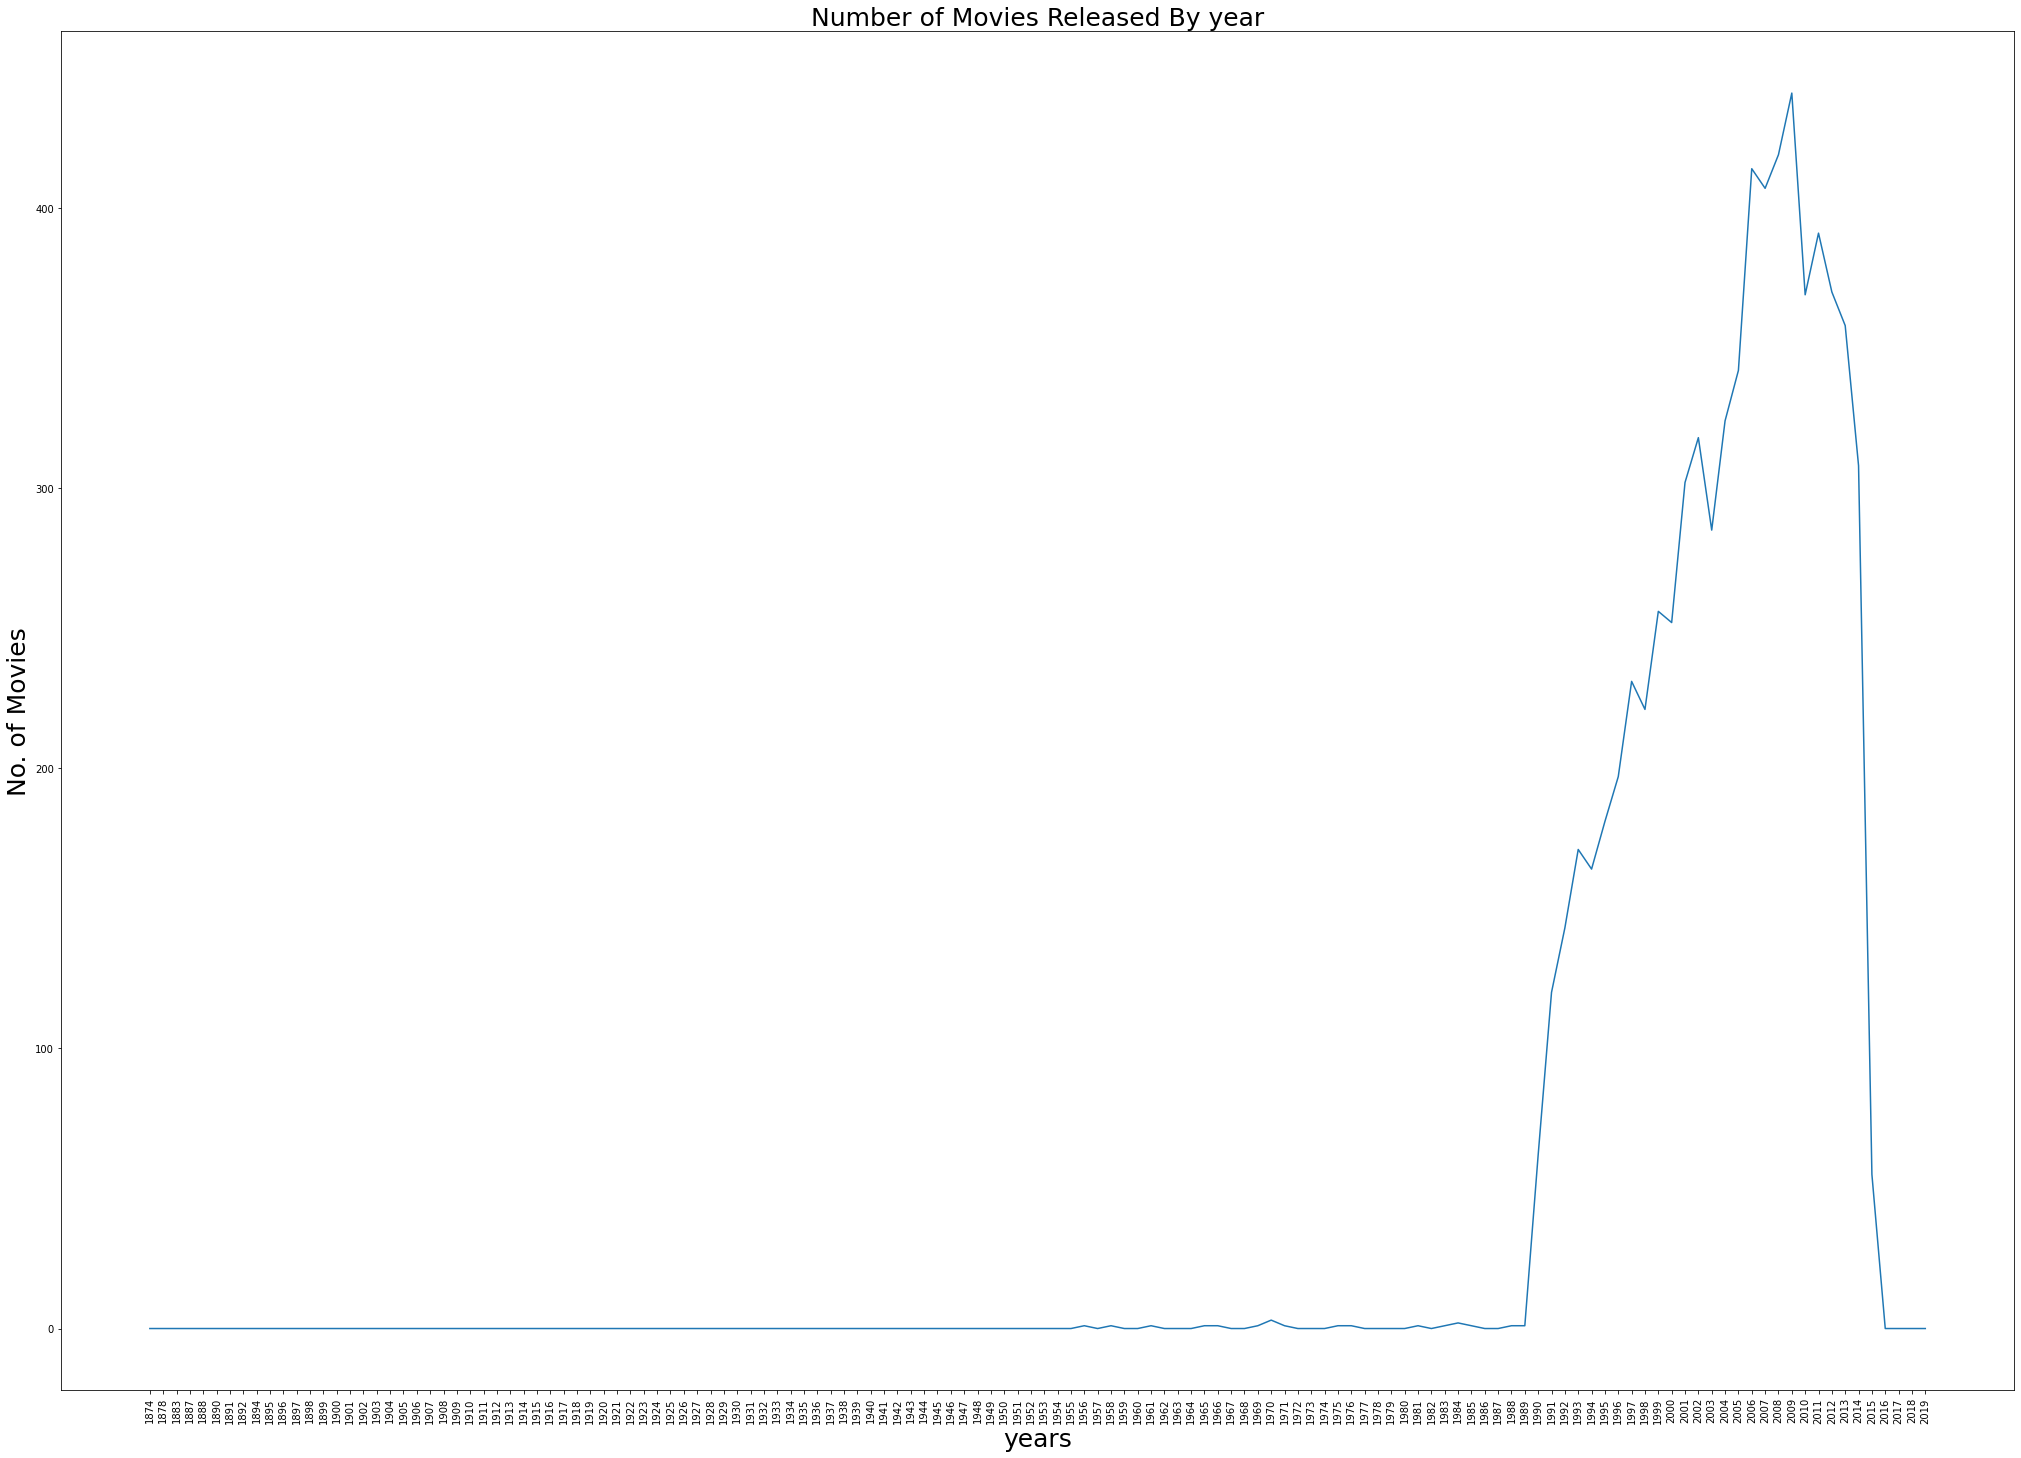

In [111]:
metadata = pd.merge(movies, imdb, on='movieId', how='left')
# The number of Movies released per year
num = metadata.groupby('year').count()
plt.figure(figsize=(35,25))
plt.plot(num.index, num['budget'])
plt.xlabel("years", size=25)
plt.xticks(rotation='vertical')
plt.ylabel('No. of Movies', size=25)
plt.title('Number of Movies Released By year', size=25)
plt.show()

Although there has been some drops in the number of movies released throughout the years, it is clear to see that there generally has been a significant growth in movies being released with the growth being exponential around 1990s.


### The number of ratings for the movies released
The general distribution of the ratings

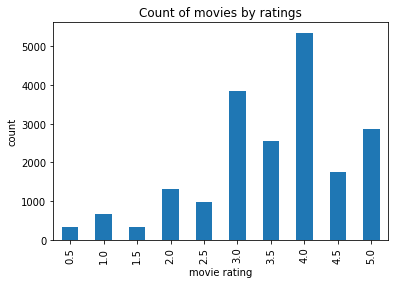

In [112]:
# Plotting the distribution
train_df = train[:20000]
Ratings = train_df['rating'].value_counts().sort_index()
Ratings.plot(kind='bar')
plt.ylabel('count')
plt.xlabel('movie rating')
plt.title('Count of movies by ratings')
plt.show()

There are more movies with ratings of 4.0, followed by 3.0, then 5.0. The issue here is that a movie may have been watched by one user and they might have given it a rating of 5.0. To curb this issue, there might be a need to consider only a movie whereby there we only 100 or more users who have watched the movie.

In [113]:
# Evaluating the number of ratings a movie has received:
no_of_ratings = train_df.groupby('movieId').count()['rating']
no_of_ratings = no_of_ratings[no_of_ratings >= 10]
new_ratings = train_df[train_df['movieId'].isin(no_of_ratings.index)]
len(new_ratings)

9072

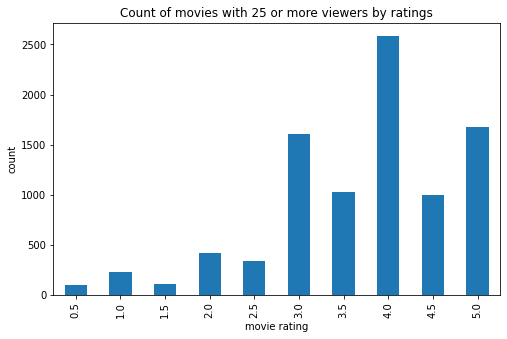

In [114]:
# Visually evaluating the number of ratings a movie has received:
num_ratings = new_ratings['rating'].value_counts().sort_index()
plt.figure(figsize=(8,5))
num_ratings.plot(kind='bar')
plt.ylabel('count')
plt.xlabel('movie rating')
plt.title('Count of movies with 25 or more viewers by ratings')
plt.show()

There are still more movies with ratings of 4.0, followed by 3.0, then 5.0, with 0.5 and 1.5 ratings being the lowest as well.

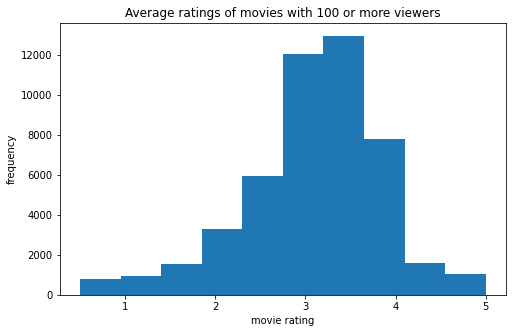

In [115]:
# The average rating of movies in the database
avg_rating = ratings_f.groupby('movieId')['rating'].mean()

# Plotting the results
plt.figure(figsize=(8,5))
avg_rating.plot(kind='hist')
plt.ylabel('frequency')
plt.xlabel('movie rating')
plt.title('Average ratings of movies with 100 or more viewers')
plt.show()

Unsuprisingly, there is a high distribution of movies in the region of 3.0 to 4.0 ratings. We now move on to wordcloud to visually summarise some of the insights we have extracted from the datasets.

### The years with majority of movies being released
Now we want to find out which years are dominating the movie industry.

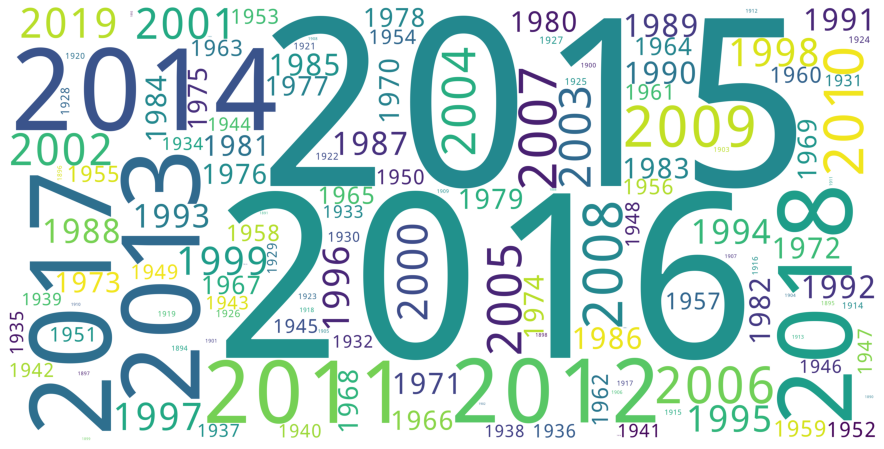

In [116]:
# Looking at the all the years of movies releases
year_corpus = metadata['year'].value_counts()
# Generating the wordcolud
year_wordcloud = WordCloud(background_color='white', height=2000, width=4000).generate_from_frequencies(year_corpus)
plt.figure(figsize=(16,8))
plt.imshow(year_wordcloud)
plt.axis('off')
plt.show()

We can see that the wordcloud is correspodning with the plot above that the movie industry grew exponentially in the 2000s, with 2015 to 2017 being the most frequent yeas of movie releases.

### The kind of movies that are being released
Now we want to find out which movies, in terms of genre are dominating the movie industry.

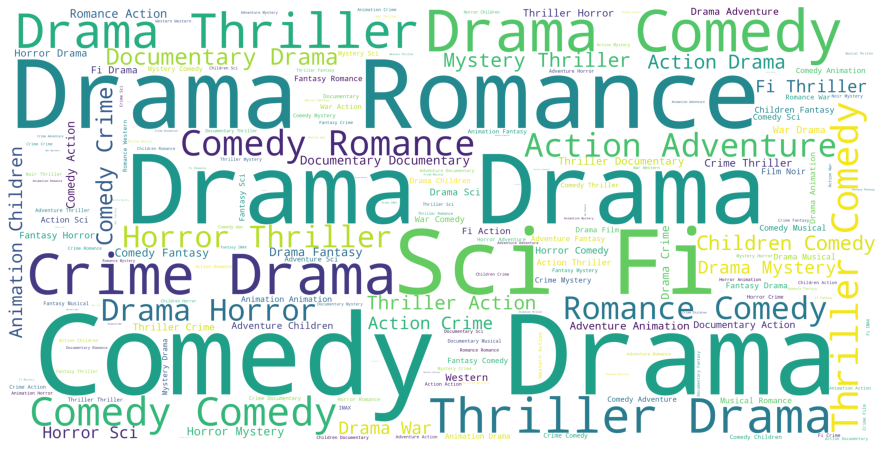

In [117]:
# Looking at the titles and checking for any similarity
metadata['genres'] = metadata['genres'].astype('str')
genre_corpus = ' '.join(metadata['genres'])
#Generating the stopwords
stopword = ['no genres', 'no', 'genres', 'genre', 'listed']
# Generating the wordcolud
genre_wordcloud = WordCloud(stopwords=stopword, background_color='white', height=2000, width=4000).generate(genre_corpus)
plt.figure(figsize=(16,8))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

We can see that majority of the movies in the dataset are Comedy, Drama and Sci-Fi.

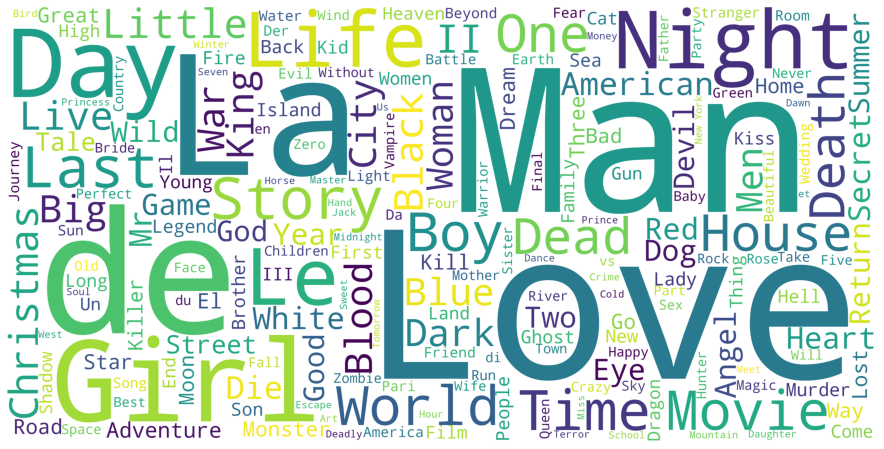

In [118]:
# Looking at the titles and checking for any similarity
metadata['title'] = metadata['title'].astype('str')
title_corpus = ' '.join(metadata['title'])
# Generating the wordcolud
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

As the worldcloud suggests, there are a lot of movies that tell the stories of a boy and/or girl as well as Love, movies about wars, crime, Day and Night events. These correspond to the genres unpacked above.

The dataset consists of 27248 movies for which we have data on overview, cast/crew and budget. This is close to only 44% of the entire dataset. Although this is less than 505 of the entire dataset, it is more than enough to perform very useful analysis and discover interesting insights about the world of movies as these play a role in profiling a user.

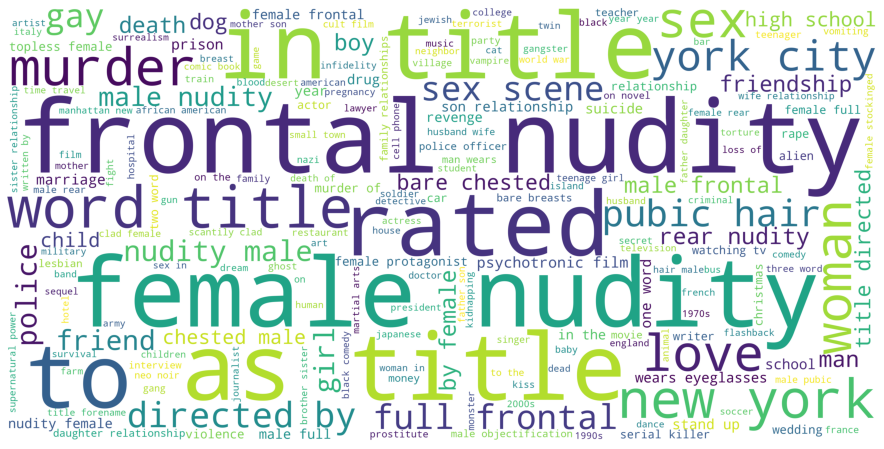

In [119]:
# Looking at the plots and checking for any similarity
metadata['plot_keywords'] = metadata['plot_keywords'].fillna(" ").astype('str')
overview_corpus = ' '.join(metadata['plot_keywords'])
# Generating the wordcolud
sw = ['based on', 'character', 'tell', 'name', 'reference', 'based', 'reference to']
plot_wordcloud = WordCloud(stopwords=sw, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(plot_wordcloud)
plt.axis('off')
plt.show()

It is key to note that the imdb dataset cosists of only 27278 entries which is only 50% of the entire movie dataframe, as such, the plot key words are not a true represenation of the whole movie database.

### The runtime of movies that are being released
Movies have progressed in terms of runtime, From the 1 minute slient, black & white clips to epic 3 hour gci. So, in this section, let us try and gain some additional insights about the nature of movie lengths and their evolution over time.

Now we want to find out the duration of these movies being released are.

In [120]:
# converting the column to numeric
metadata['runtime'] = pd.to_numeric(metadata['runtime'])

# Viewing relative durations of the movies
metadata['runtime'].describe()

count    13007.000000
mean       101.843161
std         29.879027
min          1.000000
25%         90.000000
50%         99.000000
75%        110.000000
max        877.000000
Name: runtime, dtype: float64

Off the all the movies, 13007 which is only a subset of the dataset i.e. 22%, we can see that the average length of a movie is about 1 hour and 40 minutes. The longest movie recorded in this dataset is 877 minutes (or 14 hours) long.

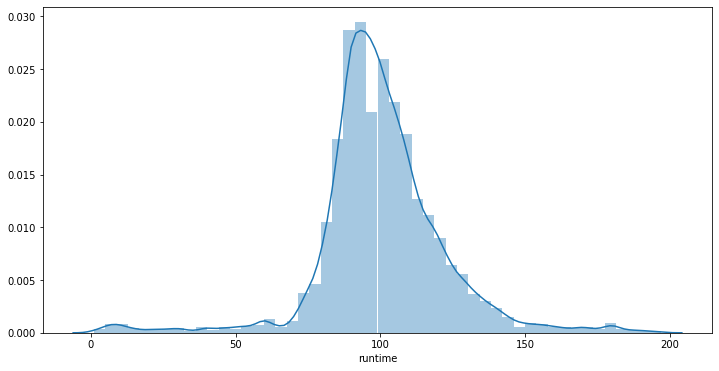

In [121]:
# The distribution of these mainstream movies .i.e movies less than 3 hours (or 200 minutes) long. 
plt.figure(figsize=(12,6))
sns.distplot(metadata[(metadata['runtime'] < 200) & (metadata['runtime'] > 0)]['runtime'])

Possible trends in what may be considered as the appropriate length of a movie across the years.

In [122]:
# Looking at the shortest Movies
metadata[metadata['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime').head(10)

,runtime,title,year
24780,1.0,Dickson Greeting,1891
22105,1.0,The Kiss,1900
23934,1.0,Stille Nacht I: Dramolet,1988
23905,1.0,Santa Claus,1898
15438,1.0,"Pyramid of Triboulet, The (La pyramide de Trib...",1899
15433,1.0,Four Heads Are Better Than One (Un homme de tête),1898
22636,2.0,Fresh Guacamole,2012
23889,2.0,Curb Dance,2010
22087,2.0,The Menacing Eye,1960
23888,3.0,Syrinx,1966


Majority of the short movies were filmed in the late 1890s and the beginning of the 20th century and they're absurdly only a minute long. The exceptn in the Top 10 are Fresh Guacamole released in 2012 and Curb Dance released in 2010 both being two minutes long.

In [123]:
# Looking at the longest Movies
metadata[metadata['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime', ascending=False).head(10)

,runtime,title,year
23255,877.0,Taken,2002
17505,750.0,Law of the Lawless (Brigada),2002
18074,644.0,Sam Peckinpah: Man of Iron,1993
19032,629.0,Death on the Staircase (Soupçons),2004
19167,600.0,New York: A Documentary Film,1999
9058,561.0,"Kingdom II, The (Riget II)",1997
7328,561.0,"Kingdom, The (Riget)",1994
12684,552.0,Into the West,2005
19175,551.0,Tie Xi Qu: West of the Tracks (Tiexi qu),2003
20022,540.0,Island at War,2004


Notably, almost all the entries in the above list were released in the 2000s and are actually miniseries and sequels and as such, can't count as feature length films. There isn't much insight we can gther from this as there is no way of distinguishing feature length films from TV Mini Series from our dataset unless done manually, and this could take days.

# 6. Modelling

Two of the most popular ways to approach recommender systems are _collaborative filtering_ and _content-based_ recommendations.

### Surprise
Surprise is a Python scikit building and analyzing recommender systems that deal with explicit rating data. We will be using it to develop and train our recommender models.

### Content Based Filtering

A Content based filter uses attributes to recommend similar content.

In a content-based recommender system, keywords are used to describe the items and a user profile is built to indicate the type of item this user likes. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past.

In [124]:
#from google.colab import files
#uploaded = files.upload()

In [125]:
#In order to best recommend a movie, we need to look at the list of movies we have. 
movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995
1,2,Jumanji,Adventure Children Fantasy,1995
2,3,Grumpier Old Men,Comedy Romance,1995
3,4,Waiting to Exhale,Comedy Drama Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


Other features that could help or influence what a user may like include the cast, director or keywords.
- This data can all be found in the imdb dataset.

In [126]:
imdb.head(3)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks Tim Allen Don Rickles Jim Varney Wal...,John Lasseter,81.0,"$30,000,000",toy rivalry cowboy cgi animation
1,2,Robin Williams Jonathan Hyde Kirsten Dunst Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game adventurer fight game
2,3,Walter Matthau Jack Lemmon Sophia Loren Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat lake neighbor rivalry


The Combined relevant datasets

The movie database has movie titles and genres and the imdb database has the cast, directors and keywords.
We make it easier to view all of this information by combining them into one dataset.  

In [127]:
alls = metadata[:20000]
alls.head(3)

,movieId,title,genres,year,title_cast,director,runtime,budget,plot_keywords
0,1,Toy Story,Adventure Animation Children Comedy Fantasy,1995,Tom Hanks Tim Allen Don Rickles Jim Varney Wal...,John Lasseter,81.0,"$30,000,000",toy rivalry cowboy cgi animation
1,2,Jumanji,Adventure Children Fantasy,1995,Robin Williams Jonathan Hyde Kirsten Dunst Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game adventurer fight game
2,3,Grumpier Old Men,Comedy Romance,1995,Walter Matthau Jack Lemmon Sophia Loren Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat lake neighbor rivalry


In [128]:
# Checking for null values
alls.isna().sum()

movieId              0
title                0
genres               0
year                 1
title_cast        8043
director          7978
runtime           9341
budget           13738
plot_keywords        0
dtype: int64

In [129]:
# Replac the null values.
alls['title_cast'] = alls['title_cast'].fillna('')
alls['director'] = alls['director'].fillna('')
alls['year'] = alls['year'].fillna(0)
alls['plot_keywords'] = alls['plot_keywords'].fillna('')
alls.isna().sum()

movieId              0
title                0
genres               0
year                 0
title_cast           0
director             0
runtime           9341
budget           13738
plot_keywords        0
dtype: int64

We obeserve that both _Runtime_ and _budget_ do not really influence a user's choice in movie preferences so we drop it these columns rather than impute them.

In [130]:
# Dropping columns that are not useful
alls = alls.drop(['runtime', 'budget'], axis = 1)
alls = alls.drop('movieId', axis = 1)

In [131]:
# Checking for missing values
alls.isna().sum()

title            0
genres           0
year             0
title_cast       0
director         0
plot_keywords    0
dtype: int64

The dataframe is now cleaned so we ensure our system does not confuse names or movies that may start with the same first words.

In [132]:
# Creating a function to clean the metadata
def clean(x):
    """ This function converts the data to lowercase and remove any spaces.
        i.e 'James Bond' is converted to 'jamesbond' and 'James Carter' to 'jamescarter'.
        This ensures that such characters don't come across as the same character.
    """
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [133]:
# Applying the cleaning function
for items in alls:
    alls[items] = alls[items].apply(clean)

# Looking at the cleaned dataframe
alls.head(3)

,title,genres,year,title_cast,director,plot_keywords
0,toystory,adventureanimationchildrencomedyfantasy,1995,tomhankstimallendonricklesjimvarneywallaceshaw...,johnlasseter,toyrivalrycowboycgianimation
1,jumanji,adventurechildrenfantasy,1995,robinwilliamsjonathanhydekirstendunstbradleypi...,jonathanhensleigh,boardgameadventurerfightgame
2,grumpieroldmen,comedyromance,1995,waltermatthaujacklemmonsophialorenann-margretb...,markstevenjohnson,boatlakeneighborrivalry


Now that we have clean the relevant data, we create our metadata soup that will be used in vectorizing. 

In [134]:
# Creating a metadata soup for vectorizing
def soup(x):
    """ This function generates normlized text values 
        thus making it easy to vectorize the text.
        i.e Loving to Love
    """ 
    return ' '.join(x['genres']) + ' ' + ' '.join(x['title_cast']) + ' ' + x['director'] + ' ' + ' '.join(x['plot_keywords'])

# Applying the function
alls['soup'] = alls.apply(soup, axis=1)

In [135]:
# We then _reset the index_ so as to generate a new dataframe setting the indices in order, 
# starting from 0, making it easier to work with the dataframe.
alls = alls.reset_index()
indices = pd.Series(alls.index, index=alls['title'])

CountVectorizer counts the word frequencies, unlike the TFIDFVectorizer we have used before in which the value increases proportionally to count, but is inversely proportional to frequency of the word in the corpus; that is the inverse document frequency (IDF) part.

CountVectorizer thus provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words. Also enabling the preprocessing of text data prior to generating the vector representation making it a highly flexible feature representation module for text.

In [136]:
# Creating the instance of cv
#data = alls['soup'][:10000]
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(alls['soup'])

Can 200 components explain majority of the variance?

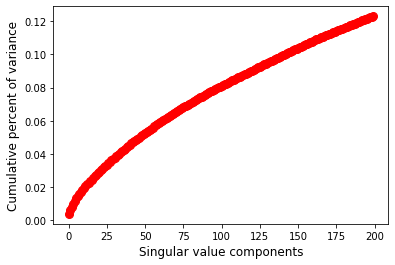

In [137]:
# Using the same number of dimensions as before
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix_2 = svd.fit_transform(count_matrix)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

This graph represents the cumulative variance that could be explained by the first 200 dimensions, which could be intepreted as one of the ways of calculating the system of coordinates i.e. variance using the SVD. It is thus another option for that we could consider for dimensionality reduction.

Dimensionality Reduction
- uncovers hidden correlations/features in the raw data.
- allows us to remove redundant and noisy features that are not useful.
- The tools help interpret and visualize the data easier.
- It also creates easier access to data storage and processing.

### Cosine Similarity

Cosine similarity is correlation, which is greater for objects with similar angles and thus of great use for data _considered to be in_ high-dimensional positive spaces. It is metric that is used to determine how similar the data is by measuring the similarity between two non-zero vectors of an inner product space by a measure of the cosine of the angle between them. It is different to the latent matrix above whereby the user and item vectors are often called latent vectors are low-dimensional embeddings. 

In [138]:
# Creating the instance of csine similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [139]:
# Creating a function to recommend movies with
def reco(title, cosine_sim = cosine_sim):
    """ This function considers all our relevant features along 
        with the cosine similarity then returns a list of recommended movies.
    
    """
    index = indices[title]

    sim_scores = list(enumerate(cosine_sim[index]))
    sims = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sims = sims[1:11]

    movie_indices = [i[0] for i in sims]

    # Return the top 10 most similar movies
    return alls['title'].iloc[movie_indices]

Finally we are now able to suggest a movie and find other similar movies for our user to watch.

### Collaborative Filtering

A technique that can filter out items that a user might like on the basis of reactions by similar users, and thus is entirely based on the past behavior and not on the context. 

- _User-User Collaborative Filtering:_ Finding look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past.
- _Item-Item Collaborative Filtering:_ It is quite similar to previous algorithm, but instead of finding user’s look-alike, we try finding movie’s look-alike.

### Movie Recommendations

##### Memory-Based Collaborative filtering
The approach is to create the user-similarity matrix wich will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items. 

Due to the limited computing power in our local machines, we will build the recommender system using only a subset of the ratings.i.e a sample of 20,000 ratings (2%).

In [140]:
# Looking at the ratings dataframe cleaned earlier
print(ratings.shape)
small_data = ratings[:20000]

(10000038, 4)


In [141]:
# Creating a new dataframe of movieId and titles
new_df = movies.loc[:,['movieId','title']]

In [158]:
# Merging data with titles to can create a pivot_table
X = pd.merge(small_data, new_df, on = 'movieId')

,userId,movieId,rating,timestamp,title
0,5163,57669,4.0,1518349992,In Bruges
1,87388,57669,3.5,1237455297,In Bruges
2,137050,57669,4.0,1425631854,In Bruges
3,120490,57669,4.5,1408228517,In Bruges
4,50616,57669,4.5,1446941640,In Bruges
...,...,...,...,...,...
19994,10503,668,4.0,938956031,Song of the Little Road (Pather Panchali)
19995,96771,6793,1.5,1300264627,Beethoven
19996,119570,874,3.0,842751579,Killer: A Journal of Murder
19997,63045,43919,2.5,1155210227,Date Movie


In [143]:
# Creating a Table to pivot table so as to compare the movies for the recommendation
table = X.pivot_table(index=['userId'], columns = ['title'],values = 'rating').fillna(0)
table.head()

title,$9.99,'71,'Salem's Lot,(500) Days of Summer,*batteries not included,...And Justice for All,10 Cloverfield Lane,10 Things I Hate About You,"10,000 BC",100 Girls,101 Dalmatians,101 Dalmatians (One Hundred and One Dalmatians),101 Rent Boys,102 Dalmatians,11.6,12 Angry Men,12 Years a Slave,127 Hours,12:08 East of Bucharest (A fost sau n-a fost?),13,13 Ghosts,13 Going on 30,13th,"13th Warrior, The",1408,1492: Conquest of Paradise,15 Minutes,16 Blocks,17 Again,1984,1984 (Nineteen Eighty-Four),1991: The Year Punk Broke,2 Days in the Valley,"2 Fast 2 Furious (Fast and the Furious 2, The)","20,000 Leagues Under the Sea",200 Cigarettes,2001: A Space Odyssey,2010: The Year We Make Contact,2012,21,...,You Don't Mess with the Zohan,You Got Served,You Kill Me,You Only Live Once,You've Got Mail,"You, Me and Dupree",Young Adam,Young Adult,Young Einstein,Young Frankenstein,Young Guns,Young Guns II,Young Sherlock Holmes,Youngblood,Your Friends and Neighbors,Your Highness,Your Name.,Youth in Revolt,ZMD: Zombies of Mass Destruction,Zack and Miri Make a Porno,Zardoz,Zeitgeist: Addendum,Zelig,Zero Dark Thirty,Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),"Zero Theorem, The",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège),Zodiac,Zombeavers,Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2),Zombieland,Zone Troopers,Zoolander,Zootopia,[REC],eXistenZ,xXx,xXx: State of the Union,¡Three Amigos!
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
# Creating a similarity table to can compare 
# the distance between movies using pearson correlation
similarity_df = table.corr(method='pearson')

Given that the user has seen a movie and rated it, we are going to recommend him another movie using the rating that he gave to the movie he has seen.

In [161]:
def find_movies(movie1,movie2,movie3):

  '''This function takes in a 3 movie and 
  suggest 10 movies you might like based 
  on the similarities they have with the 
  movies you given to it'''
      
  def find_similar(movie_name):
    score = similarity_df[movie_name]
    score = score.sort_values(ascending = False)
    return score
  movies = [movie1,movie2,movie3]
  similar_movies = pd.DataFrame()
  for movie in movies:
      similar_movies = similar_movies.append(find_similar(movie))
  similar_movies.head(10)
  return pd.DataFrame(similar_movies.sum().sort_values(ascending=False).head(13)).drop(0,axis=1)[3:]


In [163]:
#finally make the predictions
find_movies('10 Cloverfield Lane','10 Cloverfield Lane','In Bruges')

""
Curse of the Demon (Night of the Demon)
"Golden Bowl, The"
Harry Potter and the Goblet of Fire
"Cry, the Beloved Country"
Big Fish
Gattaca
"Black Hole, The"
Ivan's Childhood (a.k.a. My Name is Ivan) (Ivanovo detstvo)
$9.99
Audition (Ôdishon)


### Surprise

#### Movie ratings predictions

Basic algorithms used in recommender systems:

- NormalPredictor: predicts a random rating based on the distribution of the training set, which is assumed to be normal.
- BaselineOnly: predicts the baseline estimate for given user and item.
- KNNBasic: a basic collaborative filtering algorithm.
- KNNWithMeans: a basic collaborative filtering algorithm, taking into account the mean ratings of each user.
- KNNBaseline: is a basic collaborative filtering algorithm taking into account a baseline rating.
- SVD algorithm is equivalent to Probabilistic Matrix Factorization
- SVDpp algorithm is an extension of SVD that takes into account implicit ratings.
- NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

In [147]:
# Loading the modules and models
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from surprise import SVD, SVDpp, NormalPredictor, KNNBasic, BaselineOnly

In [148]:
# Loading in data
df = train[:10000]
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

In [149]:
# Creating data to benchmark on:
# Benchmarking algorithms
models = ['SVD', 'SVDpp', 'NormalPredictor', 'KNNBasic', 'BaselineOnly']
# empty list to capture rmse
performance = []

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)


for model in [SVD, SVDpp, NormalPredictor, KNNBasic, BaselineOnly]:
    
    # Create an instance of the model
    algo = model()
    # Fit the model to the training data
    algo.fit(trainset)
    # Generate predictions
    predictions = algo.test(testset)
    # Compare predictions against actuals
    rating_pred = accuracy.rmse(predictions)
    # Extract only the name of the model
    performance.append(rating_pred)

RMSE: 1.0424
RMSE: 1.0420
RMSE: 1.4373
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0765
Estimating biases using als...
RMSE: 1.0449


N.B we only used a subset of the data due to the local machine's storage and computing power.

In [150]:
# Creating a dataframe to store the rmse results of the models
results = pd.DataFrame(data=performance, columns=['rmse'], index=models)
# Sorting the results from best performance to worst
results.sort_values('rmse', inplace=True)
results

,rmse
SVDpp,1.041981
SVD,1.042388
BaselineOnly,1.044931
KNNBasic,1.076505
NormalPredictor,1.437293


SVD

The Singular Value Decomposition (SVD), is a matrix factorisation technique, which reduces the number of features of a dataset by reducing the space dimension from N-dimension to K-dimension (where K < N), it is of no suprise that it and the SVDpp performed best out of the other models. Since SVD and SVDpp had the least RMSE value, we will tune the hyper-parameters of them.

In [151]:
# Tuning algorithm parameters with GridSearchCV to find the best parameters for the algorithm.
# Using a subset of the data so that it runs quicker:
subset = train[:5000]
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(subset[['userId','movieId','rating']], reader)

# using the default parameters of GridSearch
from surprise.model_selection.search import GridSearchCV
param_grid = {'n_factors': [25, 30, 35, 40, 100], 'n_epochs': [15, 20, 25], 'lr_all': [0.001, 0.003, 0.005, 0.008],               'reg_all': [0.08, 0.1, 0.15, 0.02]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)
algo = gs.best_estimator['rmse']
print(gs.best_score['rmse']) 
print(gs.best_params['rmse'])

# Assigning the values
best = gs.best_params 
factors = best['rmse']['n_factors']
epochs = best['rmse']['n_epochs'] 
lr_value = best['rmse']['lr_all']
reg_value = best['rmse']['reg_all']

1.0535645405665401
{'n_factors': 30, 'n_epochs': 20, 'lr_all': 0.008, 'reg_all': 0.02}


Now we tune our model hyperparameters and train our dataset and arrive at a prediction.

In [152]:
# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD(factors, epochs, lr_value, reg_value)
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 1.1017


1.1017079046095606

We observe that our rmse has improved from 1.065454 to 1.0500. Using GridSearch on a larger dataet on cloud, we were able to tune the model again and arrived at a score of 0.8314

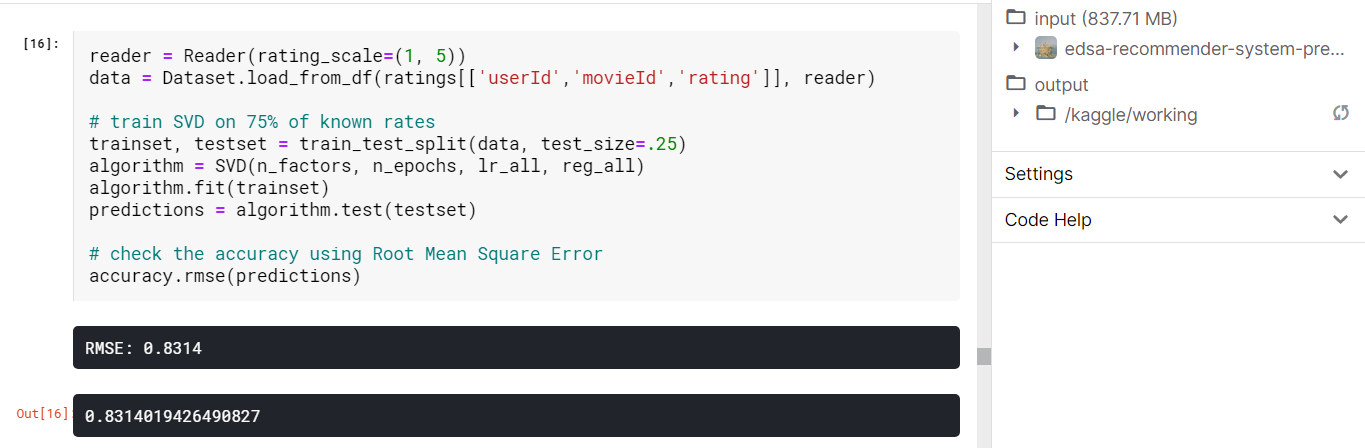

In [153]:
from IPython.display import Image
Image(filename = "data/Capture.png")

For our prediction, we give the model a different users info (userId, movieId and their rating). It will then predict an estimate of what our user may rate this movie.

#### Single rating prediction

Breakdown of what is fed into the model:


* U = userId
* I = movieId
* Ri = rating

Output
* Ro = expected rating

In [154]:
# Predicting what a user with an Id of 1 would rate a movie with Id 1 i.e Toy Story
U = 1
I = 1
Ro = algorithm.predict(U, I)
print(Ro.est)

3.810233353101258


#### Multiple ratings predictions
We use the test.csv to produce movie ratings of different movies by different users.

In [155]:
# Generating movie ratings predictions
x = []
test = test[:1000]
for row in test.itertuples():
    user = row.userId
    item = row.movieId
    test_preds = algorithm.predict(user, item)
    rating = round(test_preds.est,1)
    x.append(rating)

In [156]:
# Saving the rating predictions to the submission file
# Sample_Submission['rating'] = x

Saving this submission df as a csv and uploading to the eda recommender system competion returns a score that tells us how well our model performs on unseen data.

## 7. Performance Evaluation

#### Summary of the pros and cons of using **content-based recommendation**:

Pros
- No need for data on other users, thus no cold-start or sparsity problems.
- It includes recommendations for both new & unpopular items
- It can recommend to users with unique tastes.
Can provide explanations for recommended items that caused an item to be recommended (i.e genre and plot)

Cons
- It is rather hard to find the appropriate features to use.
- It doesn't recommend items outside users’ content profile.
- It is also unable to exploit quality judgments of other users.

#### Summary of the Memory-based Collaborative Filtering

Pros
- It is easy to implement and produce reasonable prediction quality. 

Cons
- It doesn’t address the cold-start problem, i.e. new user(s) and/or new movie enters the system.
- It suffers with sparse data, i.e. it’s hard to find users that have rated the same items.
- It alos suffers when new users or items that don’t have any ratings enter the system.
- It tends to favour and recommend popular items.

### Hybrid cosine Similarity

Alternatively we could run a content/collaborative and hybrid cosine Similarity.
Hybrid recommender systems combine two or more recommendation methods to gain better performance. Most commonly, collaborative filtering is combined with some other technique in an attempt to avoid the ramp-up problems.

from sklearn.metrics.pairwise import cosine_similarity
* We  the latent vectors for a selected movie from both content and collaborative matrixes:
a_1 = np.array(latent_matrix_1_df.loc['Toy Story']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Toy Story']).reshape(1, -1)

* Then calculate the similartity of this movie with the others in the list:
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

* To find an average measure of both content and collaborative: 
hybrid = ((score_1 + score_2)/2.0)

* Finally formulate a data frame of similar movies:
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

* Sort the dataframe on the basis of either: content, collaborative or hybrid,  i.e content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

## 8. Conclusion

## 9. References

1. Beginner Tutorial: Recommender Systems in Python
https://www.datacamp.com/community/tutorials/recommender-systems-python

2. Building Recommender Systems with Machine Learning and AI
https://explore.udemy.com/course/building-recommender-systems-with-machine-learning-and-ai/learn/lecture/18187952#overview

3. Build a Recommendation Engine With Collaborative Filtering
https://realpython.com/build-recommendation-engine-collaborative-filtering/

4. How to Build Simple Recommender Systems in Python
https://medium.com/swlh/how-to-build-simple-recommender-systems-in-python-647e5bcd78bd

5. Introduction to Recommendation System. Part 1
https://hackernoon.com/introduction-to-recommender-system-part-1-collaborative-filtering-singular-value-decomposition-44c9659c5e75

6. Building a Recommender System With Pandas
https://medium.com/towards-artificial-intelligence/building-a-recommender-system-with-pandas-1ca0bb03fdce

7. Building and Testing Recommender Systems With Surprise, Step-By-Step
https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

8. Prototyping a Recommender System Step by Step Part 1: KNN Item-Based Collaborative Filtering
https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

9. Suprise
http://surpriselib.com/

10. Simple Movie Recommender Using SVD
https://alyssaq.github.io/2015/20150426-simple-movie-recommender-using-svd/